# 21.3 — Availability and Risk Metrics (Monte Carlo)

This notebook turns repairable-system simulation outputs into **decision-grade KPIs**:

- Availability distribution (mean / P90 / P95 / P99)
- Downtime distribution (VaR-style percentiles)
- Probability of exceeding downtime thresholds
- Probability of meeting availability targets (service levels)
- Tail-risk metrics (Expected Shortfall / Conditional Mean beyond P95)
- Book-ready plots saved to `figures/` (300 DPI)

It is designed to run cleanly in **Google Colab**.

> Optional dataset: `Failure_Events_CLEAR_Enhanced.xlsx`  
If you already know Weibull parameters (β, η), set `USE_DATASET_FIT=False`.


## 0) Install dependencies (Colab)

In [3]:
# If running in Google Colab, uncomment and run once:
!pip install "numpy<2.0"
!pip -q install reliability openpyxl

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.2/257.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 57.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.4.2 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.4.2 which is incompatible.


## 1) Upload dataset (optional, Colab)

In [1]:
# If you want to fit β and η from the dataset, upload it here:
from google.colab import files
uploaded = files.upload()

Saving Failure_Events_CLEAR_Enhanced.xlsx to Failure_Events_CLEAR_Enhanced.xlsx


## 2) Imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from reliability.Fitters import Fit_Weibull_2P

## 3) Scenario inputs

You can either:
- Fit Weibull(β, η) from `Failure_Events_CLEAR_Enhanced.xlsx`, or
- Enter β and η manually

Then define:
- Repair time distribution (TTR)
- Fleet size
- Horizon
- Monte Carlo iterations


In [5]:
USE_DATASET_FIT = True

# Manual Weibull parameters (used if USE_DATASET_FIT = False)
BETA_MANUAL = 1.22
ETA_MANUAL  = 5910.9  # hours

# === Repair time (TTR) model ===
TTR_DIST = "lognormal"   # "lognormal", "normal", "fixed"
TTR_MEAN = 8.0           # hours
TTR_STD  = 4.0           # hours
TTR_FIXED = 8.0          # hours (if fixed)

# === Fleet simulation ===
N_UNITS    = 10
T_HORIZON  = 8760.0      # 1 year
N_SIM      = 10000
SEED       = 123

# === Decision thresholds (edit for your plant) ===
DOWNTIME_THRESHOLDS_H = [10, 25, 50, 100, 200]  # hours over horizon
AVAIL_TARGETS = [0.995, 0.990, 0.985, 0.980]    # service-level style targets

## 4) Get Weibull parameters (β, η)

In [6]:
DATA_FILE = "Failure_Events_CLEAR_Enhanced.xlsx"

if USE_DATASET_FIT:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(
            f"{DATA_FILE} not found. Upload it first (Section 1) or set USE_DATASET_FIT = False."
        )

    df = pd.read_excel(DATA_FILE)

    required_cols = ["Asset_ID", "Event_Type", "Failure_Start"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df["Failure_Start"] = pd.to_datetime(df["Failure_Start"], errors="coerce")
    df = df.dropna(subset=["Failure_Start"]).copy()

    FAILURE_EVENTS = {"FAILURE", "TRIP"}  # edit if needed

    df_fail = df[df["Event_Type"].astype(str).str.upper().isin(FAILURE_EVENTS)].copy()
    df_fail["Event_Type"] = df_fail["Event_Type"].astype(str).str.upper()

    df_fail = df_fail.sort_values(["Asset_ID", "Failure_Start"])
    df_fail["TTF_hours"] = df_fail.groupby("Asset_ID")["Failure_Start"].diff().dt.total_seconds() / 3600.0

    intervals = df_fail["TTF_hours"].dropna()
    intervals = intervals[intervals > 0]

    print("Derived failure intervals (hours):", len(intervals))

    OBS_END = df["Failure_Start"].max()
    last_fail = df_fail.groupby("Asset_ID")["Failure_Start"].max()
    right_censored = (OBS_END - last_fail).dt.total_seconds() / 3600.0
    right_censored = right_censored[right_censored > 0]

    fit = Fit_Weibull_2P(
        failures=intervals.values,
        right_censored=right_censored.values,
        show_probability_plot=False
    )

    beta = float(fit.beta)
    eta  = float(fit.alpha)

    print(f"Fitted β (shape): {beta:.4f}")
    print(f"Fitted η (scale): {eta:.2f} hours")
else:
    beta = float(BETA_MANUAL)
    eta  = float(ETA_MANUAL)
    print(f"Manual β (shape): {beta:.4f}")
    print(f"Manual η (scale): {eta:.2f} hours")

Derived failure intervals (hours): 113
Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 113/48 (29.81366% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         7977.34         628.256   6836.31   9308.82
     Beta         1.19621        0.088274   1.03512   1.38236 

Goodness of fit    Value
 Log-likelihood -1125.26
           AICc  2254.59
            BIC  2260.67
             AD  5.04371 

Fitted β (shape): 1.1962
Fitted η (scale): 7977.34 hours


## 5) Repair time sampler (TTR)

In [7]:
def sample_ttr(rng, size=1):
    if TTR_DIST == "fixed":
        return np.full(size, TTR_FIXED, dtype=float)

    if TTR_DIST == "normal":
        x = rng.normal(TTR_MEAN, TTR_STD, size=size)
        return np.maximum(x, 0.01)

    if TTR_DIST == "lognormal":
        mean = max(TTR_MEAN, 0.01)
        std  = max(TTR_STD, 0.01)
        var = std**2
        sigma2 = np.log(1 + var/(mean**2))
        sigma = np.sqrt(sigma2)
        mu = np.log(mean) - 0.5*sigma2
        return rng.lognormal(mean=mu, sigma=sigma, size=size)

    raise ValueError("Unknown TTR_DIST")

## 6) Repairable simulation engine

In [8]:
def simulate_one_unit_repairable(rng, beta, eta, horizon):
    t = 0.0
    downtime = 0.0
    failures = 0

    while t < horizon:
        ttf = eta * rng.weibull(beta)
        t = min(t + ttf, horizon)
        if t >= horizon:
            break

        failures += 1
        ttr = float(sample_ttr(rng, size=1)[0])
        down_end = min(t + ttr, horizon)
        downtime += max(0.0, down_end - t)
        t = down_end

    return downtime, failures


def simulate_fleet(rng, n_units, beta, eta, horizon):
    total_down = 0.0
    total_fail = 0
    for _ in range(n_units):
        d, f = simulate_one_unit_repairable(rng, beta, eta, horizon)
        total_down += d
        total_fail += f
    avail = (n_units * horizon - total_down) / (n_units * horizon)
    return total_down, total_fail, avail

## 7) Run Monte Carlo

In [9]:
rng = np.random.default_rng(SEED)

fleet_downtime = np.empty(N_SIM, dtype=float)
fleet_failures = np.empty(N_SIM, dtype=int)
fleet_avail    = np.empty(N_SIM, dtype=float)

for i in range(N_SIM):
    d, f, a = simulate_fleet(rng, N_UNITS, beta, eta, T_HORIZON)
    fleet_downtime[i] = d
    fleet_failures[i] = f
    fleet_avail[i] = a

float(fleet_downtime.mean()), float(fleet_avail.mean()), float(fleet_failures.mean())

(82.32977133567168, 0.9990601624276751, 10.2923)

## 8) Decision-grade risk metrics

In [10]:
def pct(x, p):
    return float(np.percentile(x, p))

def expected_shortfall(x, p):
    q = np.percentile(x, p)
    tail = x[x >= q]
    return float(tail.mean()) if len(tail) else float("nan")

metrics = {
    "weibull_beta": beta,
    "weibull_eta_hours": eta,
    "ttr_dist": TTR_DIST,
    "ttr_mean_hours": TTR_MEAN,
    "ttr_std_hours": TTR_STD,
    "n_units": N_UNITS,
    "horizon_hours": T_HORIZON,
    "n_sim": N_SIM,
    "downtime_mean_h": float(fleet_downtime.mean()),
    "downtime_p90_h": pct(fleet_downtime, 90),
    "downtime_p95_h": pct(fleet_downtime, 95),
    "downtime_p99_h": pct(fleet_downtime, 99),
    "downtime_ES95_h": expected_shortfall(fleet_downtime, 95),
    "avail_mean": float(fleet_avail.mean()),
    "avail_p10": pct(fleet_avail, 10),
    "avail_p5": pct(fleet_avail, 5),
    "avail_p1": pct(fleet_avail, 1),
    "avail_ES5": float(fleet_avail[fleet_avail <= np.percentile(fleet_avail, 5)].mean()),
    "failures_mean": float(fleet_failures.mean()),
    "failures_p90": pct(fleet_failures, 90),
    "failures_p95": pct(fleet_failures, 95),
    "failures_p99": pct(fleet_failures, 99),
}

pd.Series(metrics)

,0
weibull_beta,1.19621
weibull_eta_hours,7977.34
ttr_dist,lognormal
ttr_mean_hours,8
ttr_std_hours,4
n_units,10
horizon_hours,8760
n_sim,10000
downtime_mean_h,82.3298
downtime_p90_h,118.648


### Probability of exceeding downtime thresholds

In [11]:
exceed = []
for th in DOWNTIME_THRESHOLDS_H:
    exceed.append({
        "downtime_threshold_h": th,
        "prob_exceed": float(np.mean(fleet_downtime > th))
    })
exceed_df = pd.DataFrame(exceed)
exceed_df

,downtime_threshold_h,prob_exceed
0,10,0.9995
1,25,0.9924
2,50,0.8871
3,100,0.2465
4,200,0.0002


### Probability of meeting availability targets (service level)

In [12]:
svc = []
for t in AVAIL_TARGETS:
    svc.append({
        "availability_target": t,
        "prob_meet_or_exceed": float(np.mean(fleet_avail >= t))
    })
svc_df = pd.DataFrame(svc)
svc_df

,availability_target,prob_meet_or_exceed
0,0.995,1
1,0.99,1
2,0.985,1
3,0.98,1


## 9) Plots (saved to `figures/`, 300 DPI)

In [13]:
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name: str):
    path = os.path.join(FIG_DIR, name)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

### 9.1 Downtime ECDF

Saved: figures/MC_21_3_downtime_ECDF.png


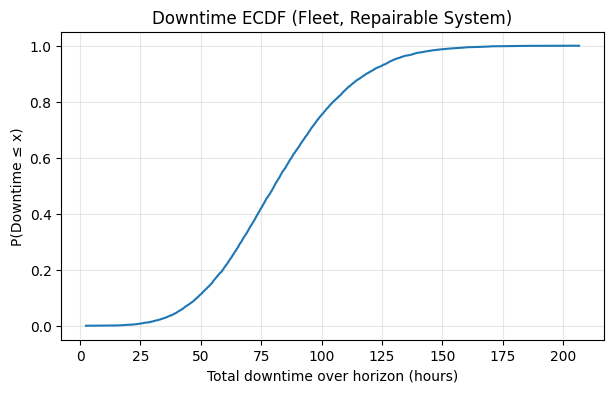

In [14]:
x = np.sort(fleet_downtime)
y = np.arange(1, len(x)+1) / len(x)

plt.figure(figsize=(7,4))
plt.plot(x, y)
plt.xlabel("Total downtime over horizon (hours)")
plt.ylabel("P(Downtime ≤ x)")
plt.title("Downtime ECDF (Fleet, Repairable System)")
plt.grid(True, alpha=0.3)
savefig("MC_21_3_downtime_ECDF.png")
plt.show()

### 9.2 Downtime exceedance curve P(Downtime > x)

Saved: figures/MC_21_3_downtime_exceedance.png


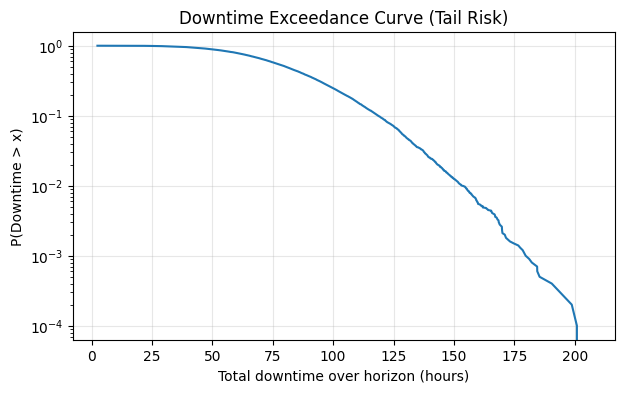

In [15]:
plt.figure(figsize=(7,4))
plt.plot(x, 1 - y)
plt.yscale("log")
plt.xlabel("Total downtime over horizon (hours)")
plt.ylabel("P(Downtime > x)")
plt.title("Downtime Exceedance Curve (Tail Risk)")
plt.grid(True, alpha=0.3)
savefig("MC_21_3_downtime_exceedance.png")
plt.show()

### 9.3 Availability CDF (lower tail = risk)

Saved: figures/MC_21_3_availability_CDF.png


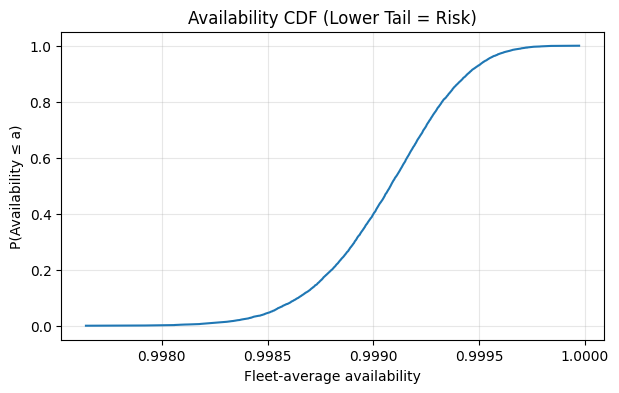

In [16]:
a = np.sort(fleet_avail)
ya = np.arange(1, len(a)+1) / len(a)

plt.figure(figsize=(7,4))
plt.plot(a, ya)
plt.xlabel("Fleet-average availability")
plt.ylabel("P(Availability ≤ a)")
plt.title("Availability CDF (Lower Tail = Risk)")
plt.grid(True, alpha=0.3)
savefig("MC_21_3_availability_CDF.png")
plt.show()

### 9.4 Downtime threshold risk bars

Saved: figures/MC_21_3_downtime_threshold_risk.png


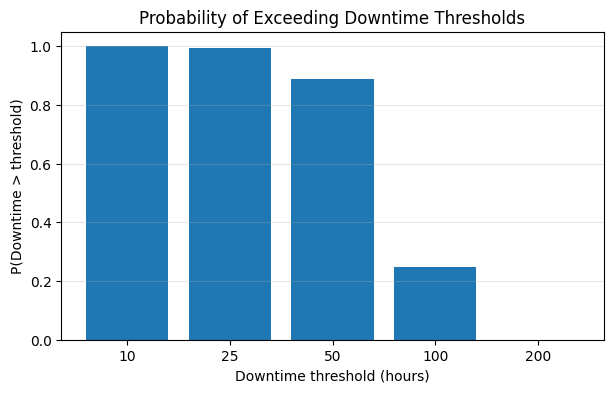

In [17]:
plt.figure(figsize=(7,4))
plt.bar(exceed_df["downtime_threshold_h"].astype(str), exceed_df["prob_exceed"])
plt.xlabel("Downtime threshold (hours)")
plt.ylabel("P(Downtime > threshold)")
plt.title("Probability of Exceeding Downtime Thresholds")
plt.grid(True, axis="y", alpha=0.3)
savefig("MC_21_3_downtime_threshold_risk.png")
plt.show()

### 9.5 Availability service level bars

Saved: figures/MC_21_3_availability_service_levels.png


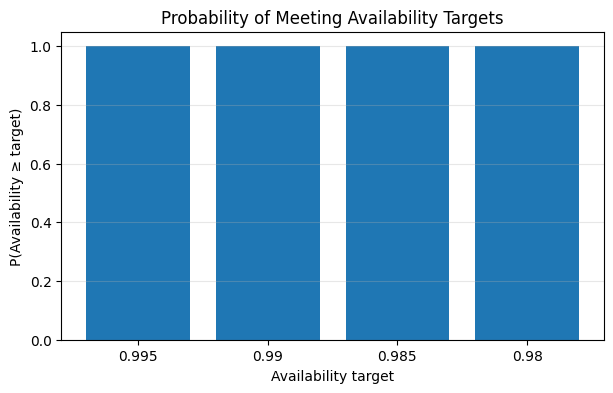

In [18]:
plt.figure(figsize=(7,4))
plt.bar(svc_df["availability_target"].astype(str), svc_df["prob_meet_or_exceed"])
plt.xlabel("Availability target")
plt.ylabel("P(Availability ≥ target)")
plt.title("Probability of Meeting Availability Targets")
plt.grid(True, axis="y", alpha=0.3)
savefig("MC_21_3_availability_service_levels.png")
plt.show()

## 10) Export results to `outputs/` (CSV)

In [19]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

metrics_df = pd.DataFrame([metrics])
metrics_path = os.path.join(OUT_DIR, "MC_21_3_availability_risk_metrics.csv")
metrics_df.to_csv(metrics_path, index=False)
print("Saved:", metrics_path)

exceed_path = os.path.join(OUT_DIR, "MC_21_3_downtime_thresholds.csv")
exceed_df.to_csv(exceed_path, index=False)
print("Saved:", exceed_path)

svc_path = os.path.join(OUT_DIR, "MC_21_3_availability_service_levels.csv")
svc_df.to_csv(svc_path, index=False)
print("Saved:", svc_path)

Saved: outputs/MC_21_3_availability_risk_metrics.csv
Saved: outputs/MC_21_3_downtime_thresholds.csv
Saved: outputs/MC_21_3_availability_service_levels.csv


## 11) Copy-ready interpretation template (for your manuscript)

In [ ]:
p95_down = metrics["downtime_p95_h"]
es95_down = metrics["downtime_ES95_h"]
avail_mean = metrics["avail_mean"]
avail_p5 = metrics["avail_p5"]

print(
f"""Copy-ready interpretation (edit as needed):

To translate repairable-system simulation outputs into decision-grade KPIs, we evaluated downtime and availability as distributions rather than point estimates.
Using Weibull failure behavior (β={beta:.3f}, η={eta:.1f} h) and a repair-time model ({TTR_DIST}, mean≈{TTR_MEAN:.1f} h, std≈{TTR_STD:.1f} h),
we simulated {N_SIM} Monte Carlo futures for a fleet of {N_UNITS} units over a horizon of {T_HORIZON:.0f} hours.

Fleet downtime has a mean of {metrics['downtime_mean_h']:.1f} hours, but tail-risk is material: P95 downtime is {p95_down:.1f} hours.
The conditional tail mean beyond P95 (Expected Shortfall) is {es95_down:.1f} hours, which captures the severity of worst-case scenarios.
Availability has a mean of {avail_mean:.4f}; however, the lower-tail risk matters operationally: the P5 availability is {avail_p5:.4f}.

Threshold-based risk metrics provide direct planning signals. For example, we compute P(total downtime > X hours) for thresholds aligned to
production loss tolerances, and P(availability ≥ target) as a reliability-style service level. These metrics connect stochastic failure/repair behavior
to operational commitments and contingency planning.

Figures: MC_21_3_downtime_ECDF.png, MC_21_3_downtime_exceedance.png, MC_21_3_availability_CDF.png,
        MC_21_3_downtime_threshold_risk.png, MC_21_3_availability_service_levels.png
"""
)

## 12) (Colab) Download figures/outputs (optional)

In [ ]:
# Uncomment in Colab:
# import shutil
# from google.colab import files
# shutil.make_archive("MC_21_3_figures", "zip", "figures")
# shutil.make_archive("MC_21_3_outputs", "zip", "outputs")
# files.download("MC_21_3_figures.zip")
# files.download("MC_21_3_outputs.zip")